<a href="https://colab.research.google.com/github/EmilyCarroll-del/Michael-J-Fox-Foundation-FOG-in-PD/blob/main/MJF_Test_Preprocessing.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
!pip install tsflex seglearn tensorflow Keras

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import seaborn as sns
from tsflex.features import FeatureCollection, MultipleFeatureDescriptors
from tsflex.features.integrations import seglearn_feature_dict_wrapper
from seglearn.feature_functions import base_features, emg_features
from sklearn.preprocessing import StandardScaler

In [ ]:
folder_path = "/content/drive/My Drive/Colab Notebooks/Test"
file_name = "Copy of 3e6987cb2d.csv"
file_path = os.path.join(folder_path, file_name)
defog_test = pd.read_csv(file_path)
defog_test.shape

(300288, 9)

In [ ]:
folder_path = "/content/drive/My Drive/Colab Notebooks/Test"
file_name = "Copy of 3ba3590a08.csv"
file_path = os.path.join(folder_path, file_name)
tdcsfog_test = pd.read_csv(file_path)
tdcsfog_test.shape

(46817, 7)

In [ ]:
#removing missing values

#defog_test dataset, valid = false, task = false
#tdcsfog has no missing values
defog_test = defog_test[defog_test['Valid']]
defog_test = defog_test[defog_test['Task']]

In [ ]:
#drop a small amount of outliers -defog_test

from scipy.stats import zscore

defog_test["AccV_z"] = zscore(defog_test["AccV"])
defog_test["AccML_z"] = zscore(defog_test["AccML"])
defog_test["AccAP_z"] = zscore(defog_test["AccAP"])

# Set threshold range for z-scores (-5 < z < 5)
threshold = 5
outliers = (defog_test["AccV_z"].abs() > threshold) | \
           (defog_test["AccML_z"].abs() > threshold) | \
           (defog_test["AccAP_z"].abs() > threshold)

defog_test = defog_test[~outliers].drop(columns=["AccV_z", "AccML_z", "AccAP_z"])

print("Number of points dropped:", outliers.sum())
print(defog_test.head())

Number of points dropped: 349
      Time      AccV     AccML     AccAP  StartHesitation  Turn  Walking  \
1000  1000 -0.976776 -0.104293  0.182096                0     0        0   
1001  1001 -0.977049 -0.106393  0.182613                0     0        0   
1002  1002 -0.975982 -0.106688  0.182188                0     0        0   
1003  1003 -0.904200 -0.080405  0.173685                0     0        0   
1004  1004 -0.985695 -0.114734  0.192869                0     0        0   

      Valid  Task  
1000   True  True  
1001   True  True  
1002   True  True  
1003   True  True  
1004   True  True  


In [ ]:
#drop a small amount of outliers -tdcsfog

tdcsfog_test["AccV_z"] = zscore(tdcsfog_test["AccV"])
tdcsfog_test["AccML_z"] = zscore(tdcsfog_test["AccML"])
tdcsfog_test["AccAP_z"] = zscore(tdcsfog_test["AccAP"])

# Set threshold range for z-scores (-5 < z < 5)
threshold = 5
outliers = (tdcsfog_test["AccV_z"].abs() > threshold) | \
           (tdcsfog_test["AccML_z"].abs() > threshold) | \
           (tdcsfog_test["AccAP_z"].abs() > threshold)

tdcsfog_test = tdcsfog_test[~outliers].drop(columns=["AccV_z", "AccML_z", "AccAP_z"])

print("Number of points dropped:", outliers.sum())
print(tdcsfog_test.head())

Number of points dropped: 235
   Time      AccV     AccML     AccAP  StartHesitation  Turn  Walking
0     0 -9.851042 -0.111723 -1.172427                0     0        0
1     1 -9.849299 -0.116912 -1.173887                0     0        0
2     2 -9.847808 -0.115431 -1.176858                0     0        0
3     3 -9.848214 -0.103538 -1.177636                0     0        0
4     4 -9.850402 -0.104952 -1.179113                0     0        0


In [ ]:
#filter the accelerometer data - defog

from scipy.signal import butter, filtfilt

fs = 100  # Sampling frequency in Hz

# Define filter parameters
lowcut = 0.25
highcut = 10.0
order = 4  # Filter order

# Create a Butterworth bandpass filter
nyquist = 0.5 * fs
low = lowcut / nyquist
high = highcut / nyquist
b, a = butter(order, [low, high], btype="band")

# Apply the filter to each accelerometer axis
defog_test["AccV_filtered"] = filtfilt(b, a, defog_test["AccV"])
defog_test["AccML_filtered"] = filtfilt(b, a, defog_test["AccML"])
defog_test["AccAP_filtered"] = filtfilt(b, a, defog_test["AccAP"])

In [ ]:
#filter the accelerometer data - tdcsfog

from scipy.signal import butter, filtfilt

fs = 128  # Sampling frequency in Hz

# Define filter parameters
lowcut = 0.25
highcut = 10.0
order = 4  # Filter order

# Create a Butterworth bandpass filter
nyquist = 0.5 * fs
low = lowcut / nyquist
high = highcut / nyquist
b, a = butter(order, [low, high], btype="band")

# Apply the filter to each accelerometer axis
tdcsfog_test["AccV_filtered"] = filtfilt(b, a, tdcsfog_test["AccV"])
tdcsfog_test["AccML_filtered"] = filtfilt(b, a, tdcsfog_test["AccML"])
tdcsfog_test["AccAP_filtered"] = filtfilt(b, a, tdcsfog_test["AccAP"])

print(tdcsfog_test.head())

   Time      AccV     AccML     AccAP  StartHesitation  Turn  Walking  \
0     0 -9.851042 -0.111723 -1.172427                0     0        0   
1     1 -9.849299 -0.116912 -1.173887                0     0        0   
2     2 -9.847808 -0.115431 -1.176858                0     0        0   
3     3 -9.848214 -0.103538 -1.177636                0     0        0   
4     4 -9.850402 -0.104952 -1.179113                0     0        0   

   AccV_filtered  AccML_filtered  AccAP_filtered  
0       0.006816       -0.002987        0.022124  
1       0.007072       -0.002236        0.019784  
2       0.007328       -0.001456        0.017684  
3       0.007589       -0.000633        0.016030  
4       0.007863        0.000221        0.014961  


In [ ]:
defog_test = defog_test.drop(columns=['AccV', 'AccML', 'AccAP'])
tdcsfog_test = tdcsfog_test.drop(columns=['AccV', 'AccML', 'AccAP'])

In [ ]:
defog_test = defog_test.reset_index(drop=True)
tdcsfog_test = tdcsfog_test.reset_index(drop=True)

In [ ]:
#SKIP OVERSAMPLING AND UNDERSAMPLING

In [ ]:
#Split the data into 6 dataframes - 1 label each
defog_turn1 = defog_test[['AccV_filtered', 'AccML_filtered', 'AccAP_filtered', 'Turn']]
defog_walk1 = defog_test[['AccV_filtered', 'AccML_filtered', 'AccAP_filtered', 'Walking']]
defog_sh1 = defog_test[['AccV_filtered', 'AccML_filtered', 'AccAP_filtered', 'StartHesitation']]

tdcsfog_turn1 = tdcsfog_test[['AccV_filtered', 'AccML_filtered', 'AccAP_filtered', 'Turn']]
tdcsfog_walk1 = tdcsfog_test[['AccV_filtered', 'AccML_filtered', 'AccAP_filtered', 'Walking']]
tdcsfog_sh1 = tdcsfog_test[['AccV_filtered', 'AccML_filtered', 'AccAP_filtered', 'StartHesitation']]

In [ ]:
#extract TIME and FREQUENCY-DOMAIN FEATURES
basic_feats = MultipleFeatureDescriptors(
    functions=seglearn_feature_dict_wrapper(base_features()),
    series_names=['AccV_filtered', 'AccML_filtered', 'AccAP_filtered'],
    windows=[300],
    strides=[100],
)

emg_feats = emg_features()
del emg_feats['simple square integral'] # is same as abs_energy (which is in base_features)

emg_feats = MultipleFeatureDescriptors(
    functions=seglearn_feature_dict_wrapper(emg_feats),
    series_names=['AccV_filtered', 'AccML_filtered', 'AccAP_filtered'],
    windows=[300],
    strides=[100]
)

fc_based = FeatureCollection([basic_feats])
fc_emgd = FeatureCollection([emg_feats])

In [ ]:
#extract TIME and FREQUENCY-DOMAIN FEATURES
basic_feats = MultipleFeatureDescriptors(
    functions=seglearn_feature_dict_wrapper(base_features()),
    series_names=['AccV_filtered', 'AccML_filtered', 'AccAP_filtered'],
    windows=[384],
    strides=[128],
)

emg_feats = emg_features()
del emg_feats['simple square integral'] # is same as abs_energy (which is in base_features)

emg_feats = MultipleFeatureDescriptors(
    functions=seglearn_feature_dict_wrapper(emg_feats),
    series_names=['AccV_filtered', 'AccML_filtered', 'AccAP_filtered'],
    windows=[384],
    strides=[128]
)

fc_baset = FeatureCollection([basic_feats])
fc_emgt = FeatureCollection([emg_feats])

In [ ]:
#calculate features - DEFOG TURN
defog_base_turn = fc_based.calculate(defog_turn1, return_df=True)
defog_emg_turn = fc_emgd.calculate(defog_turn1, return_df=True)

#reset index
defog_base_turn = defog_base_turn.reset_index(drop=True)
defog_emg_turn = defog_emg_turn.reset_index(drop=True)

#concatenate
defog_turn = pd.concat([defog_base_turn, defog_emg_turn], axis=1)

INFO:feature_calculation_logger:Finished function [[seglearn_wrapped]__mean] on [('AccV_filtered',)] with window-stride [300, ('100',)] with output ['AccV_filtered__mean__w=300'] in [0.050333971998043125 seconds]!
INFO:feature_calculation_logger:Finished function [[seglearn_wrapped]__abs_energy] on [('AccV_filtered',)] with window-stride [300, ('100',)] with output ['AccV_filtered__abs_energy__w=300'] in [0.024689824000233784 seconds]!
INFO:feature_calculation_logger:Finished function [[seglearn_wrapped]__median] on [('AccV_filtered',)] with window-stride [300, ('100',)] with output ['AccV_filtered__median__w=300'] in [0.14520447999893804 seconds]!
INFO:feature_calculation_logger:Finished function [[seglearn_wrapped]__std] on [('AccV_filtered',)] with window-stride [300, ('100',)] with output ['AccV_filtered__std__w=300'] in [0.10196150800038595 seconds]!
INFO:feature_calculation_logger:Finished function [[seglearn_wrapped]__var] on [('AccV_filtered',)] with window-stride [300, ('100',

In [ ]:
#calculate features - DEFOG Walking
defog_base_walk = fc_based.calculate(defog_walk1, return_df=True)
defog_emg_walk = fc_emgd.calculate(defog_walk1, return_df=True)

#reset index
defog_base_walk = defog_base_walk.reset_index(drop=True)
defog_emg_walk = defog_emg_walk.reset_index(drop=True)

#concatenate
defog_walk = pd.concat([defog_base_walk, defog_emg_walk], axis=1)

INFO:feature_calculation_logger:Finished function [[seglearn_wrapped]__mean] on [('AccV_filtered',)] with window-stride [300, ('100',)] with output ['AccV_filtered__mean__w=300'] in [0.05869503899884876 seconds]!
INFO:feature_calculation_logger:Finished function [[seglearn_wrapped]__abs_energy] on [('AccV_filtered',)] with window-stride [300, ('100',)] with output ['AccV_filtered__abs_energy__w=300'] in [0.02652841099916259 seconds]!
INFO:feature_calculation_logger:Finished function [[seglearn_wrapped]__median] on [('AccV_filtered',)] with window-stride [300, ('100',)] with output ['AccV_filtered__median__w=300'] in [0.1161485550001089 seconds]!
INFO:feature_calculation_logger:Finished function [[seglearn_wrapped]__std] on [('AccV_filtered',)] with window-stride [300, ('100',)] with output ['AccV_filtered__std__w=300'] in [0.10378105900235823 seconds]!
INFO:feature_calculation_logger:Finished function [[seglearn_wrapped]__var] on [('AccV_filtered',)] with window-stride [300, ('100',)] 

In [ ]:
#calculate features - DEFOG Start Hesitation
defog_base_sh = fc_based.calculate(defog_sh1, return_df=True)
defog_emg_sh = fc_emgd.calculate(defog_sh1, return_df=True)

#reset index
defog_base_sh = defog_base_sh.reset_index(drop=True)
defog_emg_sh = defog_emg_sh.reset_index(drop=True)

#concatenate
defog_sh = pd.concat([defog_base_sh, defog_emg_sh], axis=1)

INFO:feature_calculation_logger:Finished function [[seglearn_wrapped]__mean] on [('AccV_filtered',)] with window-stride [300, ('100',)] with output ['AccV_filtered__mean__w=300'] in [0.05453069199938909 seconds]!
INFO:feature_calculation_logger:Finished function [[seglearn_wrapped]__abs_energy] on [('AccV_filtered',)] with window-stride [300, ('100',)] with output ['AccV_filtered__abs_energy__w=300'] in [0.0207464799968875 seconds]!
INFO:feature_calculation_logger:Finished function [[seglearn_wrapped]__median] on [('AccV_filtered',)] with window-stride [300, ('100',)] with output ['AccV_filtered__median__w=300'] in [0.12100108499726048 seconds]!
INFO:feature_calculation_logger:Finished function [[seglearn_wrapped]__std] on [('AccV_filtered',)] with window-stride [300, ('100',)] with output ['AccV_filtered__std__w=300'] in [0.10212434599816334 seconds]!
INFO:feature_calculation_logger:Finished function [[seglearn_wrapped]__var] on [('AccV_filtered',)] with window-stride [300, ('100',)] 

In [ ]:
#calculate features - TDCSFOG TURN
tdcsfog_base_turn = fc_baset.calculate(tdcsfog_turn1, return_df=True)
tdcsfog_emg_turn = fc_emgt.calculate(tdcsfog_turn1, return_df=True)

#reset index
tdcsfog_base_turn = tdcsfog_base_turn.reset_index(drop=True)
tdcsfog_emg_turn = tdcsfog_emg_turn.reset_index(drop=True)

#concatenate
tdcsfog_turn = pd.concat([tdcsfog_base_turn, tdcsfog_emg_turn], axis=1)

INFO:feature_calculation_logger:Finished function [[seglearn_wrapped]__mean] on [('AccV_filtered',)] with window-stride [384, ('128',)] with output ['AccV_filtered__mean__w=384'] in [0.014779847999307094 seconds]!
INFO:feature_calculation_logger:Finished function [[seglearn_wrapped]__abs_energy] on [('AccV_filtered',)] with window-stride [384, ('128',)] with output ['AccV_filtered__abs_energy__w=384'] in [0.006469717001891695 seconds]!
INFO:feature_calculation_logger:Finished function [[seglearn_wrapped]__median] on [('AccV_filtered',)] with window-stride [384, ('128',)] with output ['AccV_filtered__median__w=384'] in [0.03827882900077384 seconds]!
INFO:feature_calculation_logger:Finished function [[seglearn_wrapped]__var] on [('AccV_filtered',)] with window-stride [384, ('128',)] with output ['AccV_filtered__var__w=384'] in [0.024369365997699788 seconds]!
INFO:feature_calculation_logger:Finished function [[seglearn_wrapped]__std] on [('AccV_filtered',)] with window-stride [384, ('128'

In [ ]:
#calculate features - TDCSFOG Walking
tdcsfog_base_walk = fc_baset.calculate(tdcsfog_walk1, return_df=True)
tdcsfog_emg_walk = fc_emgt.calculate(tdcsfog_walk1, return_df=True)

#reset index
tdcsfog_base_walk = tdcsfog_base_walk.reset_index(drop=True)
tdcsfog_emg_walk = tdcsfog_emg_walk.reset_index(drop=True)

#concatenate
tdcsfog_walk = pd.concat([tdcsfog_base_walk, tdcsfog_emg_walk], axis=1)

INFO:feature_calculation_logger:Finished function [[seglearn_wrapped]__mean] on [('AccV_filtered',)] with window-stride [384, ('128',)] with output ['AccV_filtered__mean__w=384'] in [0.01728434800315881 seconds]!
INFO:feature_calculation_logger:Finished function [[seglearn_wrapped]__median] on [('AccV_filtered',)] with window-stride [384, ('128',)] with output ['AccV_filtered__median__w=384'] in [0.03924994000044535 seconds]!
INFO:feature_calculation_logger:Finished function [[seglearn_wrapped]__abs_energy] on [('AccV_filtered',)] with window-stride [384, ('128',)] with output ['AccV_filtered__abs_energy__w=384'] in [0.007515901997976471 seconds]!
INFO:feature_calculation_logger:Finished function [[seglearn_wrapped]__std] on [('AccV_filtered',)] with window-stride [384, ('128',)] with output ['AccV_filtered__std__w=384'] in [0.033664534999843454 seconds]!
INFO:feature_calculation_logger:Finished function [[seglearn_wrapped]__minimum] on [('AccV_filtered',)] with window-stride [384, ('1

In [ ]:
#calculate features - TDCSFOG Start Hesitation
tdcsfog_base_sh = fc_baset.calculate(tdcsfog_sh1, return_df=True)
tdcsfog_emg_sh = fc_emgt.calculate(tdcsfog_sh1, return_df=True)

#reset index
tdcsfog_base_sh = tdcsfog_base_sh.reset_index(drop=True)
tdcsfog_emg_sh = tdcsfog_emg_sh.reset_index(drop=True)

#concatenate
tdcsfog_sh = pd.concat([tdcsfog_base_sh, tdcsfog_emg_sh], axis=1)

INFO:feature_calculation_logger:Finished function [[seglearn_wrapped]__mean] on [('AccV_filtered',)] with window-stride [384, ('128',)] with output ['AccV_filtered__mean__w=384'] in [0.09643802699793014 seconds]!
INFO:feature_calculation_logger:Finished function [[seglearn_wrapped]__abs_energy] on [('AccV_filtered',)] with window-stride [384, ('128',)] with output ['AccV_filtered__abs_energy__w=384'] in [0.053570676001982065 seconds]!
INFO:feature_calculation_logger:Finished function [[seglearn_wrapped]__median] on [('AccV_filtered',)] with window-stride [384, ('128',)] with output ['AccV_filtered__median__w=384'] in [0.3138224220019765 seconds]!
INFO:feature_calculation_logger:Finished function [[seglearn_wrapped]__std] on [('AccV_filtered',)] with window-stride [384, ('128',)] with output ['AccV_filtered__std__w=384'] in [0.16197543399903225 seconds]!
INFO:feature_calculation_logger:Finished function [[seglearn_wrapped]__minimum] on [('AccV_filtered',)] with window-stride [384, ('128

In [ ]:
#FOR DEFOG TURN

aggregated_labels = []

# Window size and stride size for the 100 Hz data
window_size = 300  # 3 seconds = 300 samples
stride_size = 100  # 1 second = 100 samples

# Iterate through the original high-frequency labels (re_defog_turn)
for start in range(0, len(defog_turn1['Turn']) - window_size + 1, stride_size):
    # Extract the labels for the current window
    window_labels = defog_turn1['Turn'][start:start + window_size]

    # Aggregation method: Numerical maximum value
    aggregated_label = max(window_labels)  # Use max to find the numerical maximum

    # Append the aggregated label to the list
    aggregated_labels.append(aggregated_label)

# Convert to DataFrame
aggregated_labels_df = pd.DataFrame({'Aggregated_Label': aggregated_labels})

# OPTIONAL: If you want to align this to your defog_turn DataFrame
# Ensure lengths of both match
if len(aggregated_labels) != len(defog_turn):
    raise ValueError("Lengths do not match. Check your aggregation logic or resampling alignment.")

# Align labels with defog_turn
defog_turn['Turn'] = aggregated_labels

In [ ]:
#DEFOG WALKING
aggregated_labels = []

window_size = 300  # 3 seconds = 300 samples
stride_size = 100  # 1 second = 100 samples

for start in range(0, len(defog_walk1['Walking']) - window_size + 1, stride_size):
    window_labels = defog_walk1['Walking'][start:start + window_size]

    # Aggregation method: Numerical maximum value
    aggregated_label = max(window_labels)  # Use max to find the numerical maximum

    aggregated_labels.append(aggregated_label)

aggregated_labels_df = pd.DataFrame({'Aggregated_Label': aggregated_labels})

if len(aggregated_labels) != len(defog_walk):
    raise ValueError("Lengths do not match. Check your aggregation logic or resampling alignment.")

# Align labels with defog_turn
defog_walk['Walking'] = aggregated_labels

In [ ]:
#DEFOG START HESITATION
aggregated_labels = []

window_size = 300  # 3 seconds = 300 samples
stride_size = 100  # 1 second = 100 samples

for start in range(0, len(defog_sh1['StartHesitation']) - window_size + 1, stride_size):
    window_labels = defog_sh1['StartHesitation'][start:start + window_size]

    # Aggregation method: Numerical maximum value
    aggregated_label = max(window_labels)  # Use max to find the numerical maximum

    aggregated_labels.append(aggregated_label)

aggregated_labels_df = pd.DataFrame({'Aggregated_Label': aggregated_labels})

if len(aggregated_labels) != len(defog_sh):
    raise ValueError("Lengths do not match. Check your aggregation logic or resampling alignment.")

# Align labels with defog_turn
defog_sh['StartHesitation'] = aggregated_labels

In [ ]:
print(defog_turn.shape)
print(defog_walk.shape)
print(defog_sh.shape)

(1285, 58)
(1285, 58)
(1285, 58)


In [ ]:
turn_count = defog_turn['Turn'].value_counts().get(1, 0)
print(f"Number of values that are 1 in the 'Turn' column: {turn_count}")

walking_count = defog_walk['Walking'].value_counts().get(1, 0)
print(f"Number of values that are 1 in the 'Walking' column: {walking_count}")

sh_count = defog_sh['StartHesitation'].value_counts().get(1, 0)
print(f"Number of values that are 1 in the 'StartHesitation' column: {sh_count}")


Number of values that are 1 in the 'Turn' column: 472
Number of values that are 1 in the 'Walking' column: 29
Number of values that are 1 in the 'StartHesitation' column: 0


In [ ]:
#TDCSFOG TURN
aggregated_labels = []

window_size = 384
stride_size = 128

for start in range(0, len(tdcsfog_turn1['Turn']) - window_size + 1, stride_size):
    window_labels = tdcsfog_turn1['Turn'][start:start + window_size]

    # Aggregation method: Numerical maximum value
    aggregated_label = max(window_labels)  # Use max to find the numerical maximum

    aggregated_labels.append(aggregated_label)

aggregated_labels_df = pd.DataFrame({'Aggregated_Label': aggregated_labels})

if len(aggregated_labels) != len(tdcsfog_turn):
    raise ValueError("Lengths do not match. Check your aggregation logic or resampling alignment.")

# Align labels with defog_turn
tdcsfog_turn['Turn'] = aggregated_labels

In [ ]:
#TDCSFOG WALKING
aggregated_labels = []

window_size = 384
stride_size = 128

for start in range(0, len(tdcsfog_walk1['Walking']) - window_size + 1, stride_size):
    window_labels = tdcsfog_walk1['Walking'][start:start + window_size]

    # Aggregation method: Numerical maximum value
    aggregated_label = max(window_labels)  # Use max to find the numerical maximum

    aggregated_labels.append(aggregated_label)

aggregated_labels_df = pd.DataFrame({'Aggregated_Label': aggregated_labels})

if len(aggregated_labels) != len(tdcsfog_walk):
    raise ValueError("Lengths do not match. Check your aggregation logic or resampling alignment.")

# Align labels with defog_turn
tdcsfog_walk['Walking'] = aggregated_labels

In [ ]:
#TDCSFOG START HESITATION
aggregated_labels = []

window_size = 384
stride_size = 128

for start in range(0, len(tdcsfog_sh1['StartHesitation']) - window_size + 1, stride_size):
    window_labels = tdcsfog_sh1['StartHesitation'][start:start + window_size]

    # Aggregation method: Numerical maximum value
    aggregated_label = max(window_labels)  # Use max to find the numerical maximum

    aggregated_labels.append(aggregated_label)

aggregated_labels_df = pd.DataFrame({'Aggregated_Label': aggregated_labels})

if len(aggregated_labels) != len(tdcsfog_sh):
    raise ValueError("Lengths do not match. Check your aggregation logic or resampling alignment.")

# Align labels with defog_turn
tdcsfog_sh['StartHesitation'] = aggregated_labels

In [ ]:
print(tdcsfog_turn.shape)
print(tdcsfog_walk.shape)
print(tdcsfog_sh.shape)

(361, 58)
(361, 58)
(361, 58)


In [ ]:
turn_count = tdcsfog_turn['Turn'].value_counts().get(1, 0)
print(f"Number of values that are 1 in the 'Turn' column: {turn_count}")

walking_count = tdcsfog_walk['Walking'].value_counts().get(1, 0)
print(f"Number of values that are 1 in the 'Walking' column: {walking_count}")

sh_count = tdcsfog_sh['StartHesitation'].value_counts().get(1, 0)
print(f"Number of values that are 1 in the 'StartHesitation' column: {sh_count}")

Number of values that are 1 in the 'Turn' column: 224
Number of values that are 1 in the 'Walking' column: 36
Number of values that are 1 in the 'StartHesitation' column: 93


In [ ]:
#CUSTOM FEATURE ENGINEERING - keep only columns kept in training dataframes

defog_turn = defog_turn[['AccAP_filtered__abs_energy__w=300', 'AccAP_filtered__kurt__w=300',
       'AccAP_filtered__mean_crossings__w=300', 'AccAP_filtered__mse__w=300',
       'AccML_filtered__abs_energy__w=300', 'AccML_filtered__kurt__w=300',
       'AccML_filtered__maximum__w=300', 'AccML_filtered__minimum__w=300',
       'AccV_filtered__abs_energy__w=300', 'AccV_filtered__kurt__w=300',
       'AccV_filtered__maximum__w=300', 'AccV_filtered__skew__w=300',
       'AccAP_filtered__waveform_length__w=300', 'Turn']]

In [ ]:
defog_walk = defog_walk[['AccAP_filtered__abs_energy__w=300', 'AccAP_filtered__kurt__w=300',
       'AccAP_filtered__maximum__w=300',
       'AccAP_filtered__mean_crossings__w=300',
       'AccAP_filtered__minimum__w=300', 'AccAP_filtered__mse__w=300',
       'AccML_filtered__abs_energy__w=300', 'AccML_filtered__kurt__w=300',
       'AccML_filtered__maximum__w=300', 'AccML_filtered__minimum__w=300',
       'AccML_filtered__mse__w=300', 'AccML_filtered__skew__w=300',
       'AccV_filtered__abs_energy__w=300', 'AccV_filtered__maximum__w=300',
       'AccV_filtered__minimum__w=300', 'Walking']]

In [ ]:
defog_sh = defog_sh[['AccAP_filtered__kurt__w=300', 'AccAP_filtered__maximum__w=300',
       'AccAP_filtered__mean__w=300', 'AccAP_filtered__mean_crossings__w=300',
       'AccAP_filtered__minimum__w=300', 'AccAP_filtered__skew__w=300',
       'AccML_filtered__abs_energy__w=300', 'AccML_filtered__maximum__w=300',
       'AccML_filtered__mean_crossings__w=300',
       'AccML_filtered__minimum__w=300', 'AccML_filtered__mse__w=300',
       'AccML_filtered__skew__w=300', 'AccV_filtered__abs_energy__w=300',
       'AccV_filtered__kurt__w=300', 'AccV_filtered__maximum__w=300',
       'AccV_filtered__minimum__w=300', 'AccV_filtered__skew__w=300',
       'AccAP_filtered__abs_sum__w=300',
       'AccAP_filtered__waveform_length__w=300',
       'AccML_filtered__waveform_length__w=300', 'StartHesitation']]

In [ ]:
tdcsfog_turn = tdcsfog_turn[['AccAP_filtered__abs_energy__w=384', 'AccAP_filtered__kurt__w=384',
       'AccAP_filtered__maximum__w=384',
       'AccAP_filtered__mean_crossings__w=384',
       'AccAP_filtered__median__w=384', 'AccAP_filtered__minimum__w=384',
       'AccAP_filtered__skew__w=384', 'AccML_filtered__abs_energy__w=384',
       'AccML_filtered__kurt__w=384', 'AccML_filtered__maximum__w=384',
       'AccML_filtered__minimum__w=384', 'AccML_filtered__skew__w=384',
       'AccV_filtered__abs_energy__w=384', 'AccV_filtered__kurt__w=384',
       'AccV_filtered__maximum__w=384', 'AccV_filtered__minimum__w=384',
       'AccV_filtered__mse__w=384', 'AccV_filtered__skew__w=384', 'Turn']]

In [ ]:
tdcsfog_walk = tdcsfog_walk[['AccAP_filtered__abs_energy__w=384', 'AccAP_filtered__kurt__w=384',
       'AccAP_filtered__maximum__w=384',
       'AccAP_filtered__mean_crossings__w=384',
       'AccAP_filtered__median__w=384', 'AccAP_filtered__minimum__w=384',
       'AccAP_filtered__mse__w=384', 'AccAP_filtered__skew__w=384',
       'AccML_filtered__abs_energy__w=384', 'AccML_filtered__maximum__w=384',
       'AccML_filtered__minimum__w=384', 'AccML_filtered__mse__w=384',
       'AccV_filtered__abs_energy__w=384', 'AccV_filtered__kurt__w=384',
       'AccV_filtered__maximum__w=384', 'AccV_filtered__minimum__w=384',
       'AccV_filtered__mse__w=384', 'AccV_filtered__skew__w=384', 'Walking']]

In [ ]:
tdcsfog_sh = tdcsfog_sh[['AccAP_filtered__abs_energy__w=384', 'AccAP_filtered__kurt__w=384',
       'AccAP_filtered__maximum__w=384',
       'AccAP_filtered__mean_crossings__w=384',
       'AccAP_filtered__median__w=384', 'AccAP_filtered__minimum__w=384',
       'AccAP_filtered__mse__w=384', 'AccAP_filtered__skew__w=384',
       'AccML_filtered__abs_energy__w=384', 'AccML_filtered__maximum__w=384',
       'AccML_filtered__minimum__w=384', 'AccML_filtered__mse__w=384',
       'AccV_filtered__abs_energy__w=384', 'AccV_filtered__kurt__w=384',
       'AccV_filtered__maximum__w=384', 'AccV_filtered__skew__w=384',
       'StartHesitation']]

In [ ]:
print(defog_turn.shape)
print(defog_walk.shape)
print(defog_sh.shape)

print(tdcsfog_turn.shape)
print(tdcsfog_walk.shape)
print(tdcsfog_sh.shape)

(1285, 14)
(1285, 16)
(1285, 21)
(361, 19)
(361, 19)
(361, 17)


In [ ]:
defog_turn.head()

,AccAP_filtered__abs_energy__w=300,AccAP_filtered__kurt__w=300,AccAP_filtered__mean_crossings__w=300,AccAP_filtered__mse__w=300,AccML_filtered__abs_energy__w=300,AccML_filtered__kurt__w=300,AccML_filtered__maximum__w=300,AccML_filtered__minimum__w=300,AccV_filtered__abs_energy__w=300,AccV_filtered__kurt__w=300,AccV_filtered__maximum__w=300,AccV_filtered__skew__w=300,AccAP_filtered__waveform_length__w=300,Turn
0,0.000737,0.298319,29.0,0.000737,0.001019,1.735034,0.001513,-0.007477,0.000322,9.140337,0.005426,-0.446429,0.081886,0
1,0.000306,-0.828795,31.0,0.000306,0.000345,8.436139,0.005933,-0.004357,0.002181,26.179990,0.018164,1.305454,0.076103,0
2,0.000322,-0.613794,28.0,0.000322,0.000302,11.191027,0.005933,-0.004357,0.002167,26.606912,0.018164,1.335553,0.073574,0
3,0.000275,-0.118484,26.0,0.000275,0.000276,14.803025,0.005933,-0.004357,0.002165,26.555257,0.018164,1.285797,0.064605,0
4,0.000249,0.252479,28.0,0.000249,0.000090,-0.363273,0.001319,-0.001488,0.000057,1.007248,0.001492,0.459363,0.060834,0


In [ ]:
defog_turn.to_csv('/content/drive/My Drive/Colab Notebooks/defog_turn_test_draft.csv')
defog_walk.to_csv('/content/drive/My Drive/Colab Notebooks/defog_walk_test_draft.csv')
defog_sh.to_csv('/content/drive/My Drive/Colab Notebooks/defog_sh_test_draft.csv')

tdcsfog_turn.to_csv('/content/drive/My Drive/Colab Notebooks/tdcsfog_turn_test_draft.csv')
tdcsfog_walk.to_csv('/content/drive/My Drive/Colab Notebooks/tdcsfog_walk_test_draft.csv')
tdcsfog_sh.to_csv('/content/drive/My Drive/Colab Notebooks/tdcsfog_sh_test_draft.csv')

Original shape: (1285, 14)
Transformed shape: (1285, 8)


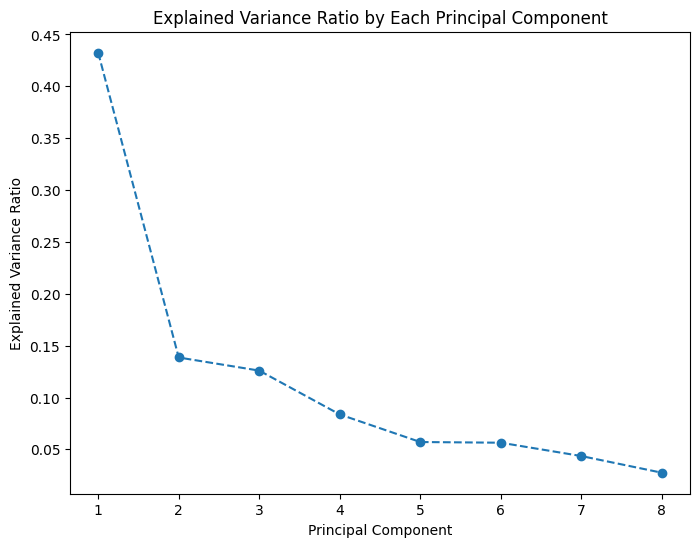

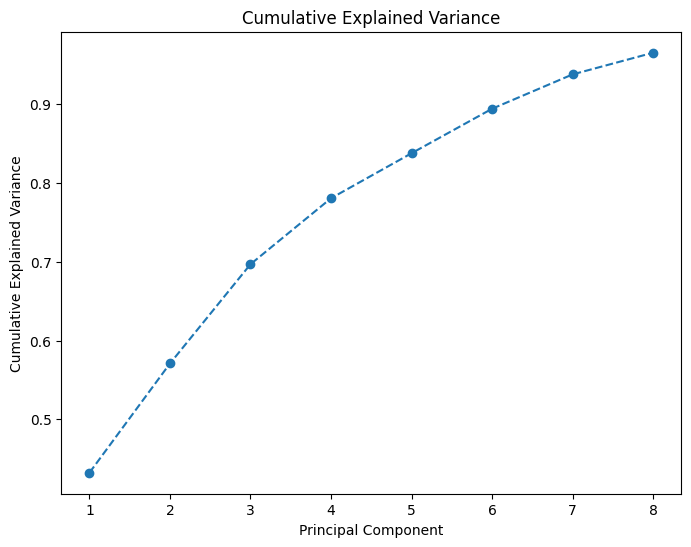

        PC1       PC2       PC3       PC4       PC5       PC6       PC7  \
0 -3.424182  0.853502  1.369316 -1.228513  1.257325  0.025733  0.617602   
1 -3.845307  3.190417  5.167813  0.606064  3.492678 -3.310944  2.121897   
2 -3.863588  3.991803  5.781850  0.856034  3.211582 -4.075466  1.544980   
3 -3.904211  4.949818  6.637177  1.027126  2.904394 -4.870988  0.590447   
4 -3.332523 -0.452414 -0.140774  0.526664  1.326574  0.756587 -0.146353   

        PC8  Turn  
0  0.046166     0  
1  0.350881     0  
2 -0.047020     0  
3 -0.652623     0  
4  0.107707     0  


In [ ]:
#PCA - dimensionality reduction

import pandas as pd
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt

# Standardize the features (PCA is affected by the scale of the data)
no_label = defog_turn.drop(columns='Turn')

scaler = StandardScaler()
X_scaled = scaler.fit_transform(no_label)

# Apply PCA
pca = PCA(n_components=0.95)  # Retain 95% of variance
X_pca = pca.fit_transform(X_scaled)

# Check the shape of the transformed data
print("Original shape:", defog_turn.shape)
print("Transformed shape:", X_pca.shape)

# Plot the explained variance ratio to see how much variance is explained by each component
plt.figure(figsize=(8, 6))
plt.plot(range(1, len(pca.explained_variance_ratio_) + 1), pca.explained_variance_ratio_, marker='o', linestyle='--')
plt.title('Explained Variance Ratio by Each Principal Component')
plt.xlabel('Principal Component')
plt.ylabel('Explained Variance Ratio')
plt.show()

# If you want to check the cumulative variance explained by the components:
plt.figure(figsize=(8, 6))
plt.plot(range(1, len(pca.explained_variance_ratio_) + 1),
         np.cumsum(pca.explained_variance_ratio_), marker='o', linestyle='--')
plt.title('Cumulative Explained Variance')
plt.xlabel('Principal Component')
plt.ylabel('Cumulative Explained Variance')
plt.show()

# Optionally, convert the PCA-transformed data back into a DataFrame
defog_turn_pca = pd.DataFrame(X_pca, columns=[f'PC{i+1}' for i in range(X_pca.shape[1])])
defog_turn_pca['Turn'] = defog_turn['Turn']

# Print the first few rows of the PCA-transformed data
print(defog_turn_pca.head())

Original shape: (1285, 15)
Transformed shape: (1285, 7)


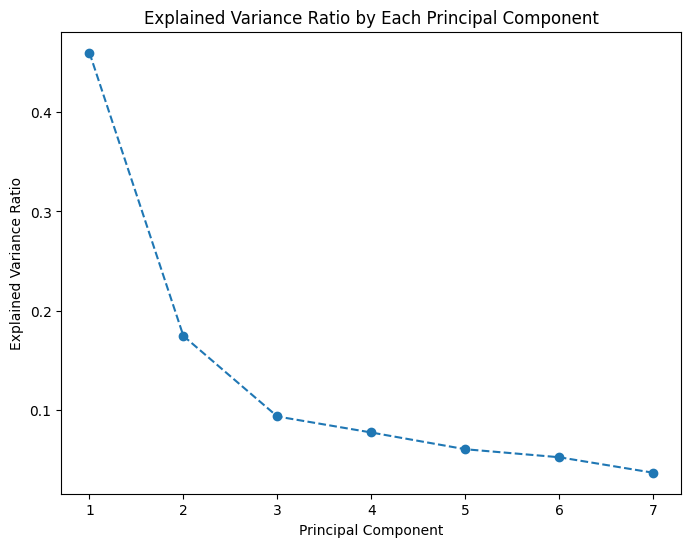

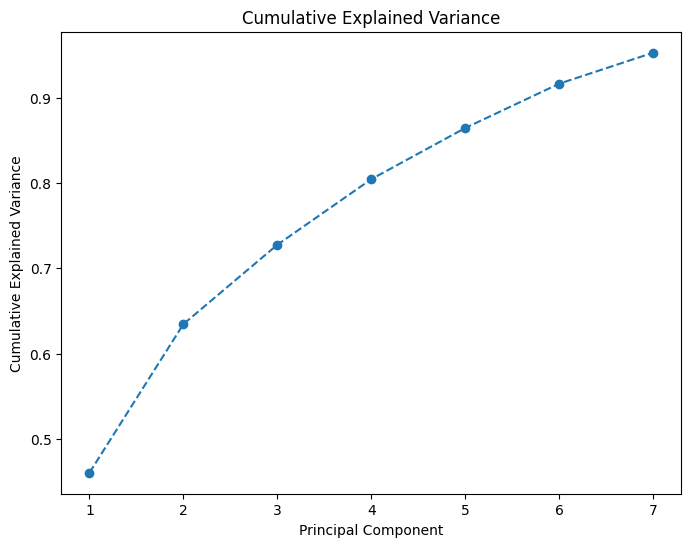

        PC1       PC2       PC3       PC4       PC5       PC6       PC7  \
0  3.207229 -0.894571  0.290688 -2.356080  0.969208  0.037675  0.519970   
1  3.229836 -1.613423  2.399581  0.616679  1.662331  2.825617  1.858760   
2  3.174041 -2.011204  3.431678  1.294434  1.406113  3.791743  2.128650   
3  3.134719 -2.467338  4.892272  1.989821  1.262300  4.954205  2.517322   
4  3.335571 -0.748752 -0.191242 -0.009706  1.204738 -0.690180  0.258047   

   Walking  
0        0  
1        0  
2        0  
3        0  
4        0  


In [ ]:
no_label = defog_walk.drop(columns='Walking')
scaler = StandardScaler()
X_scaled = scaler.fit_transform(no_label)

pca = PCA(n_components=0.95)  # Retain 95% of variance
X_pca = pca.fit_transform(X_scaled)

print("Original shape:", defog_walk.shape)
print("Transformed shape:", X_pca.shape)

# Plot the explained variance ratio to see how much variance is explained by each component
plt.figure(figsize=(8, 6))
plt.plot(range(1, len(pca.explained_variance_ratio_) + 1), pca.explained_variance_ratio_, marker='o', linestyle='--')
plt.title('Explained Variance Ratio by Each Principal Component')
plt.xlabel('Principal Component')
plt.ylabel('Explained Variance Ratio')
plt.show()

# If you want to check the cumulative variance explained by the components:
plt.figure(figsize=(8, 6))
plt.plot(range(1, len(pca.explained_variance_ratio_) + 1),
         np.cumsum(pca.explained_variance_ratio_), marker='o', linestyle='--')
plt.title('Cumulative Explained Variance')
plt.xlabel('Principal Component')
plt.ylabel('Cumulative Explained Variance')
plt.show()

# Optionally, convert the PCA-transformed data back into a DataFrame
defog_walk_pca = pd.DataFrame(X_pca, columns=[f'PC{i+1}' for i in range(X_pca.shape[1])])
defog_walk_pca['Walking'] = defog_walk['Walking']

# Print the first few rows of the PCA-transformed data
print(defog_walk_pca.head())

Original shape: (1285, 22)
Transformed shape: (1285, 10)


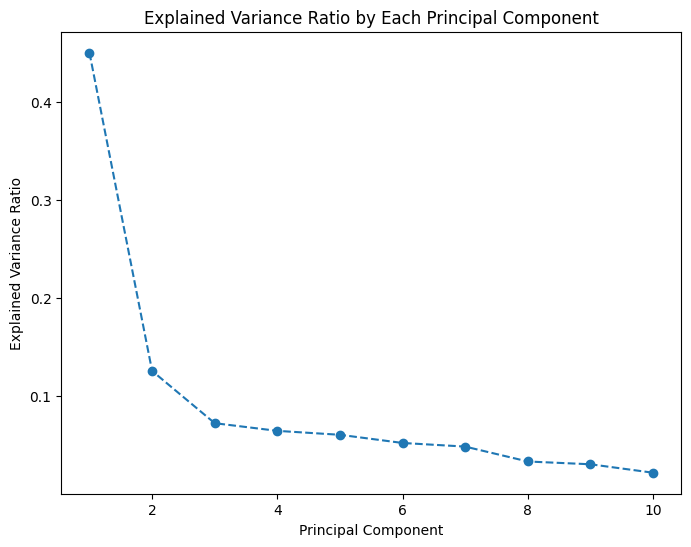

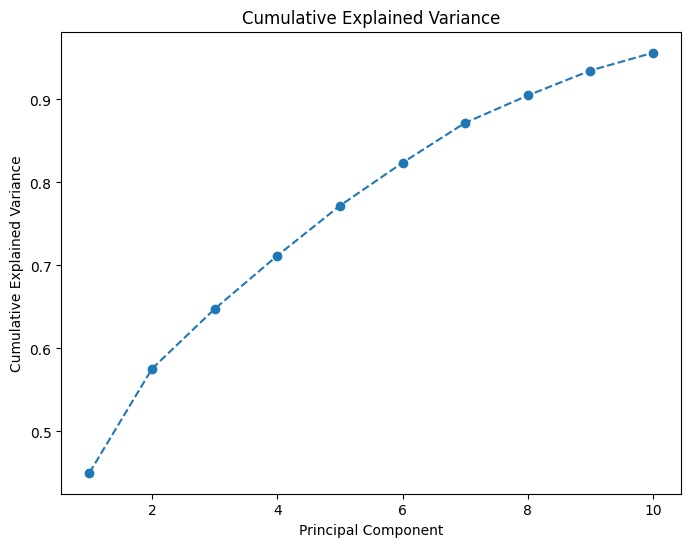

        PC1       PC2       PC3       PC4       PC5       PC6       PC7  \
0 -3.896776 -0.474489  0.423383  1.759273 -1.154105 -2.187479  0.349248   
1 -4.463194 -0.074345 -3.142045  2.268576 -1.060114  0.803064 -0.589747   
2 -4.612836 -0.252299 -3.419342  2.552868 -0.747793  1.540037 -0.903224   
3 -4.678984 -0.277867 -3.787317  2.491268 -0.794549  2.331331 -1.143103   
4 -4.526880 -0.127897 -1.076434  0.691142  1.739448  0.231329  0.177209   

        PC8       PC9      PC10  StartHesitation  
0 -0.497188  1.192400 -0.208498                0  
1 -3.696828  4.091384  0.466386                0  
2 -3.603136  4.206094  0.741942                0  
3 -3.615799  3.867133  0.628448                0  
4  0.465959  0.135758  0.326913                0  


In [ ]:
no_label = defog_sh.drop(columns='StartHesitation')
scaler = StandardScaler()
X_scaled = scaler.fit_transform(no_label)

pca = PCA(n_components=0.95)  # Retain 95% of variance
X_pca = pca.fit_transform(X_scaled)

print("Original shape:", defog_sh.shape)
print("Transformed shape:", X_pca.shape)

# Plot the explained variance ratio to see how much variance is explained by each component
plt.figure(figsize=(8, 6))
plt.plot(range(1, len(pca.explained_variance_ratio_) + 1), pca.explained_variance_ratio_, marker='o', linestyle='--')
plt.title('Explained Variance Ratio by Each Principal Component')
plt.xlabel('Principal Component')
plt.ylabel('Explained Variance Ratio')
plt.show()

# If you want to check the cumulative variance explained by the components:
plt.figure(figsize=(8, 6))
plt.plot(range(1, len(pca.explained_variance_ratio_) + 1),
         np.cumsum(pca.explained_variance_ratio_), marker='o', linestyle='--')
plt.title('Cumulative Explained Variance')
plt.xlabel('Principal Component')
plt.ylabel('Cumulative Explained Variance')
plt.show()

# Optionally, convert the PCA-transformed data back into a DataFrame
defog_sh_pca = pd.DataFrame(X_pca, columns=[f'PC{i+1}' for i in range(X_pca.shape[1])])
defog_sh_pca['StartHesitation'] = defog_sh['StartHesitation']

# Print the first few rows of the PCA-transformed data
print(defog_sh_pca.head())

Original shape: (463, 16)
Transformed shape: (463, 9)


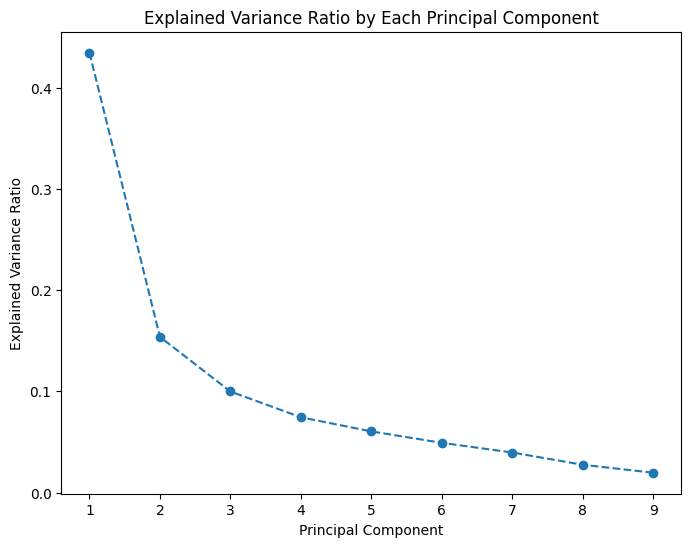

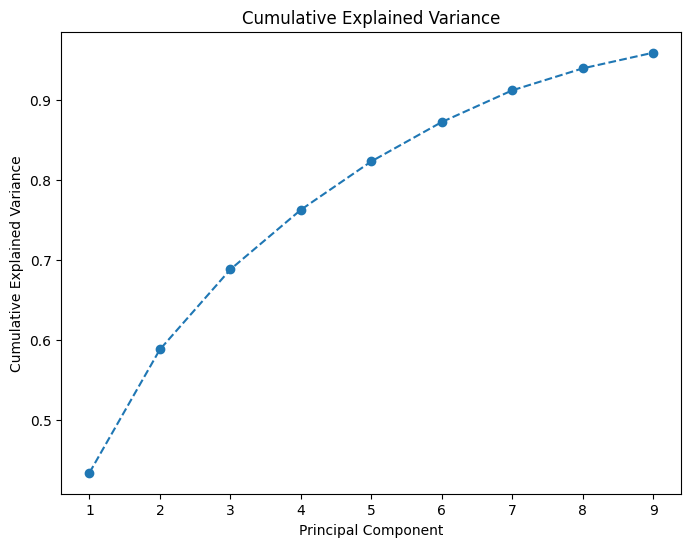

        PC1       PC2       PC3       PC4       PC5       PC6       PC7  \
0 -5.552293 -0.865973  2.973092  2.405692  0.687397 -0.978830 -0.793171   
1 -5.115027 -1.644197  3.106512  3.002483  1.818780  0.688505 -1.551583   
2 -5.507420  0.695687  2.055096  3.026834 -0.803698 -0.456341 -1.246979   
3 -5.989565  2.417734 -0.406993  1.668808 -0.966546 -1.378564 -1.440935   
4 -4.308698  5.101917  1.147931  0.966160  0.323711 -2.414689  0.599061   

        PC8       PC9  Turn  
0 -1.056614  0.827819     0  
1 -0.677619  0.768349     0  
2 -0.253593  1.023775     0  
3  0.207332  1.066988     0  
4 -0.452196 -0.198005     0  


In [ ]:
no_label = tdcsfog_turn.drop(columns='Turn')
scaler = StandardScaler()
X_scaled = scaler.fit_transform(no_label)

pca = PCA(n_components=0.95)  # Retain 95% of variance
X_pca = pca.fit_transform(X_scaled)

print("Original shape:", tdcsfog_turn.shape)
print("Transformed shape:", X_pca.shape)

# Plot the explained variance ratio to see how much variance is explained by each component
plt.figure(figsize=(8, 6))
plt.plot(range(1, len(pca.explained_variance_ratio_) + 1), pca.explained_variance_ratio_, marker='o', linestyle='--')
plt.title('Explained Variance Ratio by Each Principal Component')
plt.xlabel('Principal Component')
plt.ylabel('Explained Variance Ratio')
plt.show()

# If you want to check the cumulative variance explained by the components:
plt.figure(figsize=(8, 6))
plt.plot(range(1, len(pca.explained_variance_ratio_) + 1),
         np.cumsum(pca.explained_variance_ratio_), marker='o', linestyle='--')
plt.title('Cumulative Explained Variance')
plt.xlabel('Principal Component')
plt.ylabel('Cumulative Explained Variance')
plt.show()

# Optionally, convert the PCA-transformed data back into a DataFrame
tdcsfog_turn_pca = pd.DataFrame(X_pca, columns=[f'PC{i+1}' for i in range(X_pca.shape[1])])
tdcsfog_turn_pca['Turn'] = tdcsfog_turn['Turn']

# Print the first few rows of the PCA-transformed data
print(tdcsfog_turn_pca.head())

Original shape: (463, 17)
Transformed shape: (463, 10)


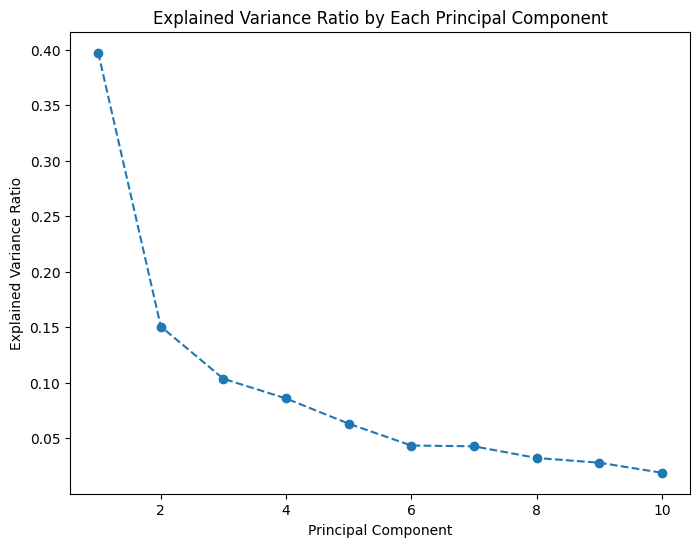

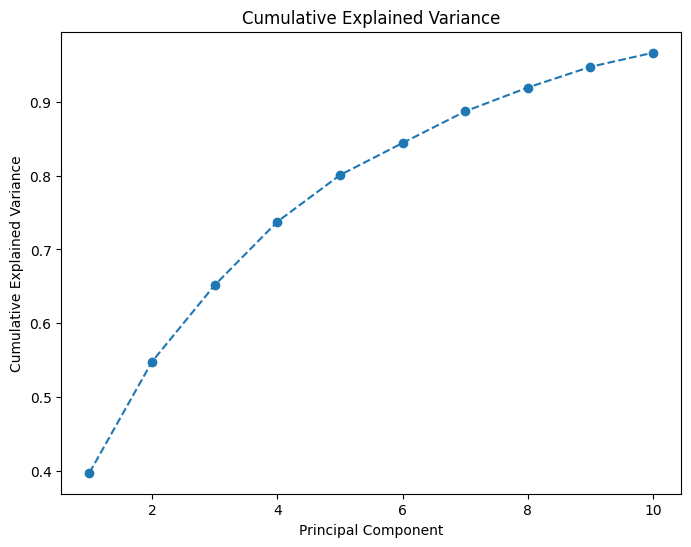

        PC1       PC2       PC3       PC4       PC5       PC6       PC7  \
0 -5.653607 -0.690735 -3.172150 -0.918757  1.857476  0.803844  0.116619   
1 -5.248088 -0.901104 -2.110743 -2.595180  3.243622 -0.102809  0.097974   
2 -5.479982  0.482821 -3.097218  0.763111  2.507857  0.992419 -0.551060   
3 -5.800829  1.575822 -1.184924  2.663521  0.738381  1.431180 -1.241551   
4 -4.146495  5.283756 -2.058834  0.887928 -0.542042  1.161409  0.084468   

        PC8       PC9      PC10  Walking  
0 -2.141514  0.648508  0.865171        0  
1 -1.785432  1.459668  0.679845        0  
2 -0.952935  1.107026  0.982117        0  
3 -1.198365  1.527215  0.936107        0  
4 -1.504522 -0.568605 -0.395518        0  


In [ ]:
no_label = tdcsfog_walk.drop(columns='Walking')
scaler = StandardScaler()
X_scaled = scaler.fit_transform(no_label)

pca = PCA(n_components=0.95)  # Retain 95% of variance
X_pca = pca.fit_transform(X_scaled)

print("Original shape:", tdcsfog_walk.shape)
print("Transformed shape:", X_pca.shape)

# Plot the explained variance ratio to see how much variance is explained by each component
plt.figure(figsize=(8, 6))
plt.plot(range(1, len(pca.explained_variance_ratio_) + 1), pca.explained_variance_ratio_, marker='o', linestyle='--')
plt.title('Explained Variance Ratio by Each Principal Component')
plt.xlabel('Principal Component')
plt.ylabel('Explained Variance Ratio')
plt.show()

# If you want to check the cumulative variance explained by the components:
plt.figure(figsize=(8, 6))
plt.plot(range(1, len(pca.explained_variance_ratio_) + 1),
         np.cumsum(pca.explained_variance_ratio_), marker='o', linestyle='--')
plt.title('Cumulative Explained Variance')
plt.xlabel('Principal Component')
plt.ylabel('Cumulative Explained Variance')
plt.show()

# Optionally, convert the PCA-transformed data back into a DataFrame
tdcsfog_walk_pca = pd.DataFrame(X_pca, columns=[f'PC{i+1}' for i in range(X_pca.shape[1])])
tdcsfog_walk_pca['Walking'] = tdcsfog_walk['Walking']

# Print the first few rows of the PCA-transformed data
print(tdcsfog_walk_pca.head())

Original shape: (463, 18)
Transformed shape: (463, 10)


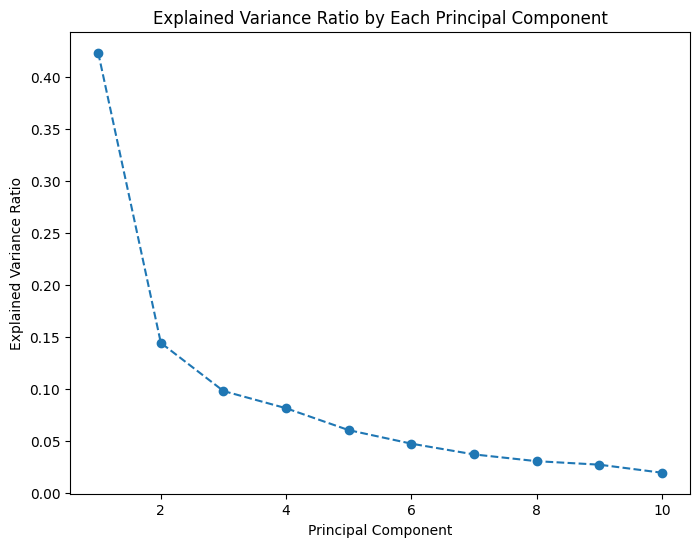

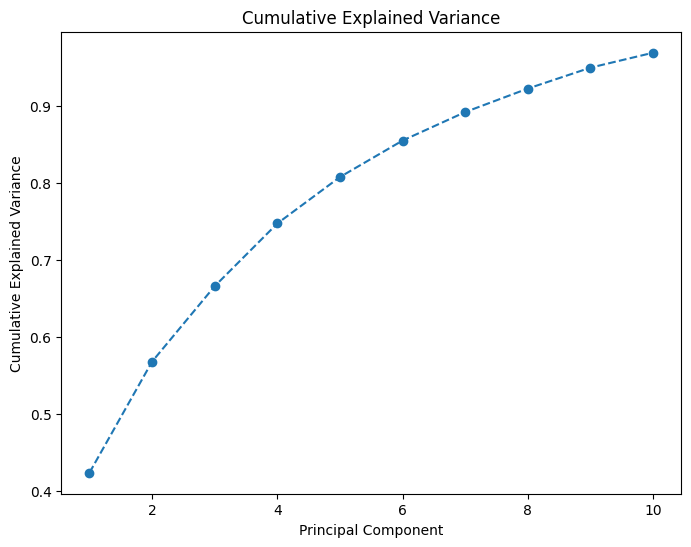

        PC1       PC2       PC3       PC4       PC5       PC6       PC7  \
0 -5.253951 -1.101492 -3.303325 -0.854613  1.952195  0.946804 -0.603359   
1 -4.905627 -1.198805 -2.140849 -2.591998  3.139448  0.263557 -0.245680   
2 -5.117702  0.059683 -3.290474  0.827928  2.625809  0.515247 -1.074761   
3 -5.471039  1.083830 -1.517895  2.909258  1.020177  0.996099 -2.153290   
4 -4.269990  4.912575 -2.381135  1.151473 -0.319478  1.541941 -0.821406   

        PC8       PC9      PC10  StartHesitation  
0 -1.873214  0.115816 -1.348421                0  
1 -1.765172  1.147256 -1.368557                0  
2 -0.661060  0.624208 -1.395365                0  
3 -0.769699  0.916689 -1.235320                0  
4 -1.169661 -0.888224  0.330104                0  


In [ ]:
no_label = tdcsfog_sh.drop(columns='StartHesitation')
scaler = StandardScaler()
X_scaled = scaler.fit_transform(no_label)

pca = PCA(n_components=0.95)  # Retain 95% of variance
X_pca = pca.fit_transform(X_scaled)

print("Original shape:", tdcsfog_sh.shape)
print("Transformed shape:", X_pca.shape)

# Plot the explained variance ratio to see how much variance is explained by each component
plt.figure(figsize=(8, 6))
plt.plot(range(1, len(pca.explained_variance_ratio_) + 1), pca.explained_variance_ratio_, marker='o', linestyle='--')
plt.title('Explained Variance Ratio by Each Principal Component')
plt.xlabel('Principal Component')
plt.ylabel('Explained Variance Ratio')
plt.show()

# If you want to check the cumulative variance explained by the components:
plt.figure(figsize=(8, 6))
plt.plot(range(1, len(pca.explained_variance_ratio_) + 1),
         np.cumsum(pca.explained_variance_ratio_), marker='o', linestyle='--')
plt.title('Cumulative Explained Variance')
plt.xlabel('Principal Component')
plt.ylabel('Cumulative Explained Variance')
plt.show()

# Optionally, convert the PCA-transformed data back into a DataFrame
tdcsfog_sh_pca = pd.DataFrame(X_pca, columns=[f'PC{i+1}' for i in range(X_pca.shape[1])])
tdcsfog_sh_pca['StartHesitation'] = tdcsfog_sh['StartHesitation']

# Print the first few rows of the PCA-transformed data
print(tdcsfog_sh_pca.head())